In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
train_data = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/data/데이콘/스타2/train.pkl')
test_data = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/data/데이콘/스타2/test.pkl')

train_time = np.load('/content/drive/My Drive/Colab Notebooks/data/데이콘/스타2/train_time.npy')
test_time = np.load('/content/drive/My Drive/Colab Notebooks/data/데이콘/스타2/test_time.npy')
train_data['time'] = train_time
test_data['time'] = test_time

In [3]:
train_data.head()

,game_id,winner,time,player,species,event,event_contents
0,0.0,1.0,0.00,0.0,0.0,0.0,"at (145.25, 21.5078125)"
1,0.0,1.0,0.00,1.0,0.0,0.0,"at (22.75, 147.0078125)"
2,0.0,1.0,0.02,0.0,0.0,1.0,['OrbitalCommand [3080001]']
3,0.0,1.0,0.02,0.0,0.0,2.0,(1360) - TrainSCV
4,0.0,1.0,0.14,0.0,0.0,0.0,"at (142.99609375, 24.50390625)"


In [0]:
data=train_data
#data= test_data

컬럼 생성 인사이트
- 경기의 초반부와 후반부를 나눔
- 초반에 승패를 결정할 요인은 무엇일까?
  - 테크 트리, 일꾼 생산(완료)
- 후반에 승패를 경정할 요인은 무엇일까?
  - 후반 생산 유닛/전체 게임 유닛, 컨트롤 여부

# 건물 테크 트리 시간차

In [0]:
# player별 분리
data_0=data[data['player'] == 0]
data_1=data[data['player'] == 1]
data_0=data_0[data_0['event']==2][['game_id','time','event_contents']]
data_1=data_1[data_1['event']==2][['game_id','time','event_contents']]

data_0= data_0[(data_0['event_contents'].str.contains('Build'))|
               (data_0['event_contents'].str.contains('Morph'))|
               (data_0['event_contents'].str.contains('MorphTo'))]
data_1= data_1[(data_1['event_contents'].str.contains('Build'))|
               (data_1['event_contents'].str.contains('Morph'))|
               (data_1['event_contents'].str.contains('MorphTo'))]

## player_0

In [0]:
# data_0['event_contents'].str.extract(r'(?P<x>Build)([A-Z][\w]+)')

In [0]:
data_0['event_contents']=data_0['event_contents'].apply(lambda x: x.split(';')[0][9:][5:])

In [80]:
data_0

,game_id,time,event_contents
19,0.0,0.27,SupplyDepot
87,0.0,1.00,Barracks
104,0.0,1.09,Refinery
184,0.0,2.14,CommandCenter
226,0.0,2.32,SupplyDepot
...,...,...,...
67091434,38871.0,7.47,Drone
67091438,38871.0,7.48,CreepTumor
67091606,38871.0,8.19,Drone
67091682,38871.0,8.37,Drone


Morph, MorphTo 명령어에 건물이 아닌 일꾼 또는 병력이 잡히기 때문에 이것들을 없애주자. 또한 Defense 건물도 없애주자.

In [0]:
No_techtree=['Larva','Drone','Queen','Zergling','Baneling','Roach','Ravager','Hydralisk','Lurker',
             'Infestor','InfestedTerran','SwarmHost','Locust','Ultralisk','Overlord','Overseer','TransportOverlord',
             'Changeling','Mutalisk','Corruptor','Viper','BroodLord','Broodling','PhotonCannon','MissileTurret',
             'SpineCrawler','SporeCrawler','Bunker','Building']

In [82]:
data_0[data_0['event_contents'].isin(No_techtree)]['event_contents'].value_counts()

Drone            145489
Overlord          45791
Zergling          42476
Roach              9262
MissileTurret      7156
PhotonCannon       6751
Building           6583
SporeCrawler       6033
SpineCrawler       4051
Bunker             3333
Hydralisk          1692
Mutalisk            828
SwarmHost            99
Corruptor            43
Infestor             15
Ultralisk             2
Name: event_contents, dtype: int64

In [0]:
data_0=data_0[data_0['event_contents'].isin(No_techtree)==False]

In [0]:
data_0=data_0.groupby(['game_id','event_contents'])['time'].first().reset_index()

In [0]:
data_0=data_0.sort_values(by=["game_id", "time"], ascending=[True, True])

In [0]:
max_time_0=data_0.groupby('game_id')['time'].sum().reset_index()

In [87]:
max_tech_count_0 = data_0['game_id'].value_counts().reset_index(name= 'count')
max_tech_count_0.rename(columns={'index':'game_id'},inplace=True)
max_tech_count_0.head()

,game_id,count
0,11642.0,17
1,2525.0,16
2,36487.0,16
3,5435.0,15
4,16827.0,15


In [88]:
player_0=max_time_0.merge(max_tech_count_0,on='game_id')
player_0['[time/count]_0']=player_0['time'] / player_0['count']
player_0.head()

,game_id,time,count,[time/count]_0
0,0.0,31.960001,10,3.196000
1,1.0,33.270000,9,3.696667
2,2.0,43.139999,9,4.793333
3,3.0,34.180000,10,3.418000
4,4.0,20.389999,8,2.548750


## player_1

In [0]:
data_1['event_contents']=data_1['event_contents'].apply(lambda x: x.split(';')[0][9:][5:])

In [90]:
data_1.head()

,game_id,time,event_contents
43,0.0,0.37,SupplyDepot
56,0.0,0.40,Refinery
124,0.0,1.21,Barracks
223,0.0,2.30,SupplyDepot
311,0.0,2.52,Factory


In [91]:
No_techtree=['Larva','Drone','Queen','Zergling','Baneling','Roach','Ravager','Hydralisk','Lurker',
             'Infestor','InfestedTerran','SwarmHost','Locust','Ultralisk','Overlord','Overseer','TransportOverlord',
             'Changeling','Mutalisk','Corruptor','Viper','BroodLord','Broodling','PhotonCannon','MissileTurret',
             'SpineCrawler','SporeCrawler','Bunker','Building']

data_1[data_1['event_contents'].isin(No_techtree)]['event_contents'].value_counts()

Drone            141765
Overlord          44909
Zergling          40940
Roach              8938
MissileTurret      7269
PhotonCannon       7162
Building           6704
SporeCrawler       5597
SpineCrawler       4124
Bunker             3318
Hydralisk          1628
Mutalisk            806
SwarmHost            71
Corruptor            23
Infestor             18
Name: event_contents, dtype: int64

In [92]:
data_1=data_1[data_1['event_contents'].isin(No_techtree)==False]
data_1=data_1.groupby(['game_id','event_contents'])['time'].first().reset_index()
data_1=data_1.sort_values(by=["game_id", "time"], ascending=[True, True])

max_time_1=data_1.groupby('game_id')['time'].sum().reset_index()
max_tech_count_1 = data_1['game_id'].value_counts().reset_index(name= 'count')
max_tech_count_1.rename(columns={'index':'game_id'},inplace=True)
max_tech_count_1.head()

player_1=max_time_1.merge(max_tech_count_1,on='game_id')
player_1['[time/count]_1']=player_1['time'] / player_1['count']
player_1.head()

,game_id,time,count,[time/count]_1
0,0.0,19.680000,7,2.811429
1,1.0,32.000000,10,3.200000
2,2.0,33.580002,7,4.797143
3,3.0,35.779999,8,4.472500
4,4.0,18.190001,5,3.638000


## merge

In [0]:
merge_13 = pd.DataFrame({'game_id':data['game_id'].unique()})

In [0]:
merge_13 = merge_13.merge(player_0,on='game_id',how='left')\
.merge(player_1,on='game_id',how='left')

In [0]:
# train 일때만
merge_13['winner'] = data.groupby('game_id')['winner'].max().values

In [96]:
col_list=['game_id','techtime_0','techcount_0','time/count_0','techtime_1','techcount_1','time/count_1','winner']
merge_13.columns = col_list
merge_13.head()

,game_id,techtime_0,techcount_0,time/count_0,techtime_1,techcount_1,time/count_1,winner
0,0.0,31.960001,10.0,3.196000,19.680000,7.0,2.811429,1.0
1,1.0,33.270000,9.0,3.696667,32.000000,10.0,3.200000,1.0
2,2.0,43.139999,9.0,4.793333,33.580002,7.0,4.797143,0.0
3,3.0,34.180000,10.0,3.418000,35.779999,8.0,4.472500,0.0
4,4.0,20.389999,8.0,2.548750,18.190001,5.0,3.638000,0.0


In [97]:
# delta값 만들기
merge_13['techtime_delta'] = merge_13['techtime_0'] - merge_13['techtime_1']
merge_13['techcount_delta'] = merge_13['techcount_0'] - merge_13['techcount_1']
merge_13['time/count_delta'] = merge_13['time/count_0'] - merge_13['time/count_1']
merge_13.head()

,game_id,techtime_0,techcount_0,time/count_0,techtime_1,techcount_1,time/count_1,winner,techtime_delta,techcount_delta,time/count_delta
0,0.0,31.960001,10.0,3.196000,19.680000,7.0,2.811429,1.0,12.280001,3.0,0.384572
1,1.0,33.270000,9.0,3.696667,32.000000,10.0,3.200000,1.0,1.270000,-1.0,0.496667
2,2.0,43.139999,9.0,4.793333,33.580002,7.0,4.797143,0.0,9.559998,2.0,-0.003810
3,3.0,34.180000,10.0,3.418000,35.779999,8.0,4.472500,0.0,-1.599998,2.0,-1.054500
4,4.0,20.389999,8.0,2.548750,18.190001,5.0,3.638000,0.0,2.199999,3.0,-1.089250


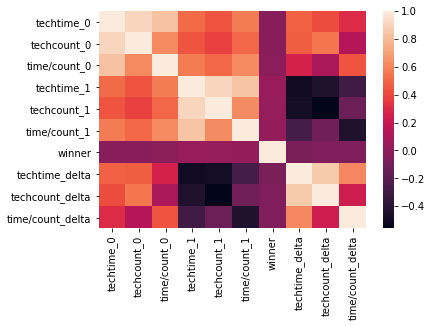

In [98]:
#그래프 그리기

#sns.pairplot(merge_13.drop('game_id',axis=1),hue="winner")
#sns.pairplot(merge_13[['[time/count]_0','[time/count]_1','winner']],hue="winner")
sns.heatmap(merge_13.drop('game_id',axis=1).corr())

In [99]:
merge_13.drop('game_id',axis=1).corr()['winner']

techtime_0         -0.028509
techcount_0        -0.028418
time/count_0       -0.016339
techtime_1          0.033066
techcount_1         0.031310
time/count_1        0.024130
winner              1.000000
techtime_delta     -0.067640
techcount_delta    -0.058778
time/count_delta   -0.053741
Name: winner, dtype: float64

In [0]:
# 저장
merge_13.to_csv('/content/drive/My Drive/Colab Notebooks/data/데이콘/스타2/merge_13_train.csv')